# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

#Import Scikit-learn and Imbalanced-learn relevant libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.metrics import classification_report_imbalanced

## Read the CSV and Perform Basic Data Cleaning

In [2]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


## Split the Data into Training and Testing

In [3]:
# Perform a binary encoding on several columns we want to use to feed the models
# By looking at the file, I identified 3 columns that we should encode - 'home_ownership', 'verification_status','application_type'
df_encoded = pd.get_dummies(df, columns=['home_ownership', 'verification_status','application_type'])
df_encoded.head()

,loan_amnt,int_rate,installment,annual_inc,issue_d,loan_status,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,...,debt_settlement_flag,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,application_type_Individual,application_type_Joint App
0,10500.0,0.1719,375.35,66000.0,Mar-2019,low_risk,n,27.24,0.0,0.0,...,N,0,0,0,1,0,1,0,1,0
1,25000.0,0.2000,929.09,105000.0,Mar-2019,low_risk,n,20.23,0.0,0.0,...,N,0,1,0,0,0,0,1,1,0
2,20000.0,0.2000,529.88,56000.0,Mar-2019,low_risk,n,24.26,0.0,0.0,...,N,0,1,0,0,0,0,1,1,0
3,10000.0,0.1640,353.55,92000.0,Mar-2019,low_risk,n,31.44,0.0,1.0,...,N,0,0,0,1,0,0,1,1,0
4,22000.0,0.1474,520.39,52000.0,Mar-2019,low_risk,n,18.76,0.0,1.0,...,N,0,1,0,0,1,0,0,1,0


In [4]:
# check the content of columns we might want to remove (either contain same value accross the entire data
# or considered irrelevant)
df_encoded['debt_settlement_flag'].describe() # I will remove that one since it contains only one value

count     68817
unique        1
top           N
freq      68817
Name: debt_settlement_flag, dtype: object

In [5]:
df_encoded['pymnt_plan'].describe() # I will remove that one since it contains only one value

count     68817
unique        1
top           n
freq      68817
Name: pymnt_plan, dtype: object

In [6]:
df_encoded['hardship_flag'].describe() # I will remove that one since it contains only one value

count     68817
unique        1
top           N
freq      68817
Name: hardship_flag, dtype: object

In [7]:
# Create our features
# I drop the columns deemed irrelevant for our model = timeseries columns and the ones with a single value 
X = df_encoded.drop(columns=['loan_status','issue_d','pymnt_plan','initial_list_status','next_pymnt_d', 'hardship_flag', 'debt_settlement_flag'])

# Create our target
y = df_encoded['loan_status']

In [8]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,total_il_high_credit_limit,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,application_type_Individual,application_type_Joint App
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,5.572240e+04,0.009285,0.526309,0.106747,0.357659,0.478007,0.373992,0.148001,0.860340,0.139660
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,5.095845e+04,0.095914,0.499311,0.308793,0.479314,0.499520,0.483865,0.355104,0.346637,0.346637
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,1.270000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,2.288000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,4.200000e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,7.249900e+04,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.426964e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [10]:
# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,total_il_high_credit_limit,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,application_type_Individual,application_type_Joint App
3903,1600.0,0.0881,50.74,35964.0,24.12,0.0,0.0,20.0,0.0,1156.0,...,15000.0,0,0,1,0,1,0,0,1,0
28390,9000.0,0.0756,280.21,41000.0,16.89,1.0,0.0,16.0,0.0,11157.0,...,40492.0,0,0,1,0,1,0,0,1,0
15470,10000.0,0.1033,214.10,112000.0,17.75,0.0,0.0,14.0,0.0,16904.0,...,80642.0,0,1,0,0,0,0,1,1,0
4279,36000.0,0.1033,1167.21,120000.0,19.95,0.0,1.0,13.0,0.0,63248.0,...,30000.0,0,0,0,1,1,0,0,1,0
57514,18000.0,0.0881,570.81,51000.0,19.11,1.0,0.0,16.0,0.0,17586.0,...,96715.0,0,1,0,0,0,0,1,1,0


## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [11]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [12]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [13]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [14]:
# Resample the training data with the BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
model_brf = brf.fit(X_train_scaled, y_train)

In [15]:
# Calculated the balanced accuracy score
y_pred_brf = model_brf.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred_brf)

0.7019248580611102

In [16]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred_brf)

array([[   59,    42],
       [ 3084, 14020]])

In [17]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_brf))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.58      0.82      0.04      0.69      0.47       101
   low_risk       1.00      0.82      0.58      0.90      0.69      0.49     17104

avg / total       0.99      0.82      0.59      0.89      0.69      0.49     17205



In [18]:
# List the features sorted in descending order by feature importance
features_importance = pd.DataFrame (sorted(zip(model_brf.feature_importances_, X.columns), reverse=True))
features_importance.head(10)

,0,1
0,0.073004,last_pymnt_amnt
1,0.070647,total_rec_prncp
2,0.064337,total_rec_int
3,0.051896,total_pymnt_inv
4,0.040181,int_rate
5,0.039396,total_pymnt
6,0.021432,mths_since_recent_inq
7,0.020768,dti
8,0.018211,max_bal_bc
9,0.016966,mths_since_rcnt_il



Bad key savefig.frameon in file /opt/anaconda3/envs/finance/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /opt/anaconda3/envs/finance/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /opt/anaconda3/envs/finance/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably 

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

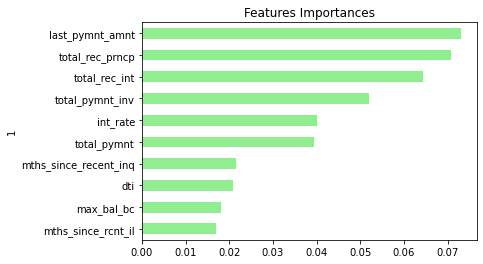

In [19]:
# Visualize the features by importance
x = features_importance.iloc[0:10]
x.set_index(x[1], inplace=True)
x.drop(columns=1, inplace=True)
x.rename(columns={0:'Feature Importances'}, inplace=True)
x = x.sort_values(by='Feature Importances')
x.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

### Easy Ensemble Classifier

In [20]:
# Train the Classifier
eec = EasyEnsembleClassifier(n_estimators=100, random_state=1)
model_ecc = eec.fit(X_train_scaled, y_train)

In [21]:
# Calculated the balanced accuracy score
y_pred_ecc = model_ecc.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred_ecc)

0.7239800891922682

In [22]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred_ecc)

array([[   69,    32],
       [ 4023, 13081]])

In [23]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_ecc))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.68      0.76      0.03      0.72      0.52       101
   low_risk       1.00      0.76      0.68      0.87      0.72      0.53     17104

avg / total       0.99      0.76      0.68      0.86      0.72      0.53     17205



### Final Questions

1. Which model had the best balanced accuracy score?

    The Easy Ensemble Classifier produces the best balanced accuracy score between the two models. 

2. Which model had the best recall score?

    The Balanced Random Forest Classifier produces the best recall score at 0.82 Vs 0.76

3. Which model had the best geometric mean score?

    The Balanced Random Forest Classifier produces the best f1 score at 0.89 Vs 0.86

4. What are the top three features?

    The top three features are : 'last_pymnt_amnt' (7.3%), 'total_rec_prncp' (7%) and 'total_rec_int' (6.4%)
